## DSC-609: Machine Learning
### Module 2 - Regularization
**Michael Albers**

**7/17/2022**

### Overview
Use Ridge and LASSO regression to predict Life Expectancy

### Data Set
**Life Expectancy (WHO)** 

This data set contains immunization data, mortality, economic, and social factors, and other health related factors from 2000 to 2015 from world countries.

https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [573]:
%matplotlib inline

In [574]:
# set default theme
sns.set_theme()

In [575]:
import warnings
warnings.filterwarnings('ignore')

In [576]:
# Load libraries for Ridge and LASSO regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

### Read and Inspect data file

In [577]:
life_exp_df = pd.read_csv('data/Life Expectancy Data.csv')

In [578]:
life_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [617]:
# Rename columns
life_exp_df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
life_exp_df.rename(columns=lambda x: x.strip().lower().replace("/", "_"), inplace=True)
life_exp_df.rename(columns=lambda x: x.strip().lower().replace("__", "_"), inplace=True)
life_exp_df.rename(columns=lambda x: x.strip().lower().replace("-", "_"), inplace=True)
life_exp_df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [618]:
life_exp_df['status'].value_counts()

Developing    2426
Developed      512
Name: status, dtype: int64

In [619]:
life_exp_df['year'].value_counts(sort=False)

2015    183
2014    183
2013    193
2012    183
2011    183
2010    183
2009    183
2008    183
2007    183
2006    183
2005    183
2004    183
2003    183
2002    183
2001    183
2000    183
Name: year, dtype: int64

#### Take copy of data frame

In [620]:
life_exp_df_copy = life_exp_df.copy()

In [621]:
life_exp_df_copy.set_index('country', inplace=True)

#### The predicitons on life expectancy will be based on year 2015

In [622]:
le_2015 = life_exp_df[life_exp_df['year'] == 2015]

In [623]:
le_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 2922
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          183 non-null    object 
 1   year                             183 non-null    int64  
 2   status                           183 non-null    object 
 3   life_expectancy                  183 non-null    float64
 4   adult_mortality                  183 non-null    float64
 5   infant_deaths                    183 non-null    int64  
 6   alcohol                          6 non-null      float64
 7   percentage_expenditure           183 non-null    float64
 8   hepatitis_b                      174 non-null    float64
 9   measles                          183 non-null    int64  
 10  bmi                              181 non-null    float64
 11  under_five_deaths                183 non-null    int64  
 12  polio                

In [624]:
le_2015.sample(12)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
673,Cyprus,2015,Developed,85.0,52.0,0,NaN,0.0,97.0,0,...,97.0,NaN,97.0,0.1,2375.112700,116985.0,1.0,1.0,0.854,14.3
576,Colombia,2015,Developing,74.8,143.0,10,NaN,0.0,91.0,1,...,91.0,NaN,91.0,0.1,644.525556,48228697.0,2.1,1.9,0.724,13.6
1975,Papua New Guinea,2015,Developing,62.9,275.0,10,NaN,0.0,67.0,38,...,74.0,NaN,73.0,0.6,NaN,7919825.0,1.3,1.3,0.515,10.0
432,Côte d'Ivoire,2015,Developing,53.3,397.0,57,NaN,0.0,83.0,65,...,81.0,NaN,83.0,1.9,NaN,NaN,5.5,5.5,NaN,NaN
2281,Seychelles,2015,Developing,73.2,168.0,0,NaN,0.0,98.0,0,...,97.0,NaN,97.0,0.1,1539.464000,93419.0,5.7,6.0,0.781,14.1
496,Canada,2015,Developing,82.2,64.0,2,NaN,0.0,55.0,195,...,91.0,NaN,91.0,0.1,43315.744000,3584861.0,0.6,0.5,0.919,16.3
1090,Guinea-Bissau,2015,Developing,58.9,275.0,4,NaN,0.0,87.0,153,...,87.0,NaN,87.0,3.2,596.871719,177526.0,7.1,7.0,0.421,9.2
144,Azerbaijan,2015,Developing,72.7,118.0,5,NaN,0.0,96.0,0,...,98.0,NaN,96.0,0.1,55.313820,9649341.0,2.8,2.9,0.758,12.7
1764,Mozambique,2015,Developing,57.6,355.0,60,NaN,0.0,8.0,79,...,8.0,NaN,8.0,3.9,528.312560,281691.0,3.6,3.5,0.414,9.1
336,Botswana,2015,Developing,65.7,256.0,2,NaN,0.0,95.0,0,...,96.0,NaN,95.0,2.2,6532.651000,229197.0,6.4,6.1,0.698,12.6


#### Check for duplicate records

In [625]:
duplicate_rec_count = le_2015[le_2015.duplicated(['country', 'year', 'status']) == True]

In [626]:
len(duplicate_rec_count)

0

In [627]:
msg = f'There are {len(duplicate_rec_count)} duplicate rows'

In [628]:
print(msg)

There are 0 duplicate rows


#### Check for missing data

In [629]:
def report_missing_data(col_name):
    '''
    Description: Check if col_name parameter is missing any values
    
    args: col_name - name of dataframe column
    
    returns: column name if missing values. Otherwise return None
    '''
    
    num_missing = le_2015[col_name].isnull().sum()
    msg = f'{col_name} has {num_missing} missing values'
    
    if (num_missing > 0):
        print(msg)
        return col_name
        
    return None

In [633]:
column_names = ['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling']

In [634]:
missing_col_names = []

In [635]:
for c in column_names:
    col_ret = report_missing_data(c)
    
    if col_ret != None:
        missing_col_names.append(c)

alcohol has 177 missing values
hepatitis_b has 9 missing values
bmi has 2 missing values
total_expenditure has 181 missing values
gdp has 29 missing values
population has 41 missing values
thinness_1_19_years has 2 missing values
thinness_5_9_years has 2 missing values
income_composition_of_resources has 10 missing values
schooling has 10 missing values


In [636]:
missing_col_names

['alcohol',
 'hepatitis_b',
 'bmi',
 'total_expenditure',
 'gdp',
 'population',
 'thinness_1_19_years',
 'thinness_5_9_years',
 'income_composition_of_resources',
 'schooling']

In [637]:
# drop 'alcohol' and 'total_expenditure' feature since columns are mostly empty
cols_to_drop = ['alcohol','total_expenditure']

In [638]:
le_2015.drop(cols_to_drop, axis=1, inplace=True)

In [639]:
le_2015.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'percentage_expenditure', 'hepatitis_b', 'measles',
       'bmi', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp',
       'population', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

In [640]:
missing_col_names_new = [c for c in missing_col_names if c not in cols_to_drop]

In [641]:
missing_col_names_new

['hepatitis_b',
 'bmi',
 'gdp',
 'population',
 'thinness_1_19_years',
 'thinness_5_9_years',
 'income_composition_of_resources',
 'schooling']

In [642]:
le_2015[missing_col_names_new].isnull().sum()

hepatitis_b                         9
bmi                                 2
gdp                                29
population                         41
thinness_1_19_years                 2
thinness_5_9_years                  2
income_composition_of_resources    10
schooling                          10
dtype: int64

#### Calculate means for missing columns by Country

In [643]:
new_df = life_exp_df_copy[missing_col_names_new].fillna(0)

In [644]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   hepatitis_b                      2938 non-null   float64
 1   bmi                              2938 non-null   float64
 2   gdp                              2938 non-null   float64
 3   population                       2938 non-null   float64
 4   thinness_1_19_years              2938 non-null   float64
 5   thinness_5_9_years               2938 non-null   float64
 6   income_composition_of_resources  2938 non-null   float64
 7   schooling                        2938 non-null   float64
dtypes: float64(8)
memory usage: 206.6+ KB


In [645]:
# Calculate column means by country
le_country_means = new_df.groupby('country')[missing_col_names_new].mean()

In [646]:
le_country_means.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   hepatitis_b                      193 non-null    float64
 1   bmi                              193 non-null    float64
 2   gdp                              193 non-null    float64
 3   population                       193 non-null    float64
 4   thinness_1_19_years              193 non-null    float64
 5   thinness_5_9_years               193 non-null    float64
 6   income_composition_of_resources  193 non-null    float64
 7   schooling                        193 non-null    float64
dtypes: float64(8)
memory usage: 13.6+ KB


In [647]:
le_country_means.head(12)

,hepatitis_b,bmi,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,
Afghanistan,64.5625,15.51875,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
Albania,98.0000,49.06875,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
Algeria,58.5000,48.74375,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
Angola,39.5000,18.01875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
Antigua and Barbuda,92.1250,38.42500,9759.305728,0.000000e+00,3.42500,3.37500,0.488625,8.84375
Argentina,71.1250,54.98125,6998.575103,2.012120e+07,1.07500,0.95000,0.794125,16.50625
Armenia,87.5625,44.70625,1999.986318,1.015165e+06,2.03750,2.11250,0.698375,11.78750
Australia,87.5625,55.86250,34637.565047,4.587010e+06,0.66875,0.62500,0.918125,20.03750
Austria,81.0625,48.28750,33827.476309,6.474880e+06,1.73125,1.93750,0.862375,15.38750


#### Impute missing values

> Fill missing values with the mean values calculated by country

In [648]:
le_2015.set_index('country', inplace=True)

In [649]:
le_2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, Afghanistan to Zimbabwe
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             183 non-null    int64  
 1   status                           183 non-null    object 
 2   life_expectancy                  183 non-null    float64
 3   adult_mortality                  183 non-null    float64
 4   infant_deaths                    183 non-null    int64  
 5   percentage_expenditure           183 non-null    float64
 6   hepatitis_b                      174 non-null    float64
 7   measles                          183 non-null    int64  
 8   bmi                              181 non-null    float64
 9   under_five_deaths                183 non-null    int64  
 10  polio                            183 non-null    float64
 11  diphtheria                       183 non-null    float64
 12  hiv_aids    

In [650]:
def impute_missing_values(col_name):
    '''
    Description: fill missing values for col_name argument to mean of col_name
    
    args: col_name - data frame column name
    '''
    le_2015[col_name].fillna(le_country_means[col_name], inplace=True)
    

In [651]:
for mc in missing_col_names_new:
    impute_missing_values(mc)

In [652]:
# final check for missing values
le_2015.isnull().sum()

year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under_five_deaths                  0
polio                              0
diphtheria                         0
hiv_aids                           0
gdp                                0
population                         0
thinness_1_19_years                0
thinness_5_9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [653]:
le_2015.sample(12)

,year,status,life_expectancy,adult_mortality,infant_deaths,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,,
Dominican Republic,2015,Developing,73.9,152.0,6,0.0,81.0,0,58.9,7,87.0,85.0,0.3,6468.471648,1528394.0,3.3,3.2,0.718,13.2
Republic of Korea,2015,Developing,82.3,64.0,1,0.0,98.0,7,31.7,2,98.0,98.0,0.1,0.000000,0.0,1.5,1.0,0.000,0.0
Seychelles,2015,Developing,73.2,168.0,0,0.0,98.0,0,37.4,0,97.0,97.0,0.1,1539.464000,93419.0,5.7,6.0,0.781,14.1
Namibia,2015,Developing,65.8,248.0,2,0.0,92.0,212,35.7,3,92.0,92.0,2.1,4737.669960,2425561.0,8.2,8.1,0.637,11.7
Ukraine,2015,Developing,71.3,195.0,4,0.0,22.0,105,61.3,5,51.0,23.0,0.2,2124.662666,4515429.0,2.3,2.4,0.748,15.3
Bulgaria,2015,Developed,74.5,137.0,0,0.0,92.0,0,65.7,1,91.0,91.0,0.1,6993.477360,7177991.0,1.9,1.8,0.792,15.0
Chile,2015,Developing,85.0,82.0,2,0.0,97.0,9,63.8,2,96.0,96.0,0.1,13653.226400,17762681.0,0.8,0.8,0.845,16.3
Croatia,2015,Developed,78.0,95.0,0,0.0,94.0,206,63.7,0,94.0,94.0,0.1,11579.667400,42364.0,1.5,1.4,0.823,15.3
Oman,2015,Developing,76.6,99.0,1,0.0,99.0,0,54.6,1,99.0,99.0,0.1,16627.364330,0.0,7.1,6.9,0.795,13.7


In [654]:
# backup of life expectancy 2015 data
le_2015.to_csv('data/le_2015.csv')

### EDA (Exploratory Data Analysis)

#### Check for Outliers

In [655]:
le_2015.columns

Index(['year', 'status', 'life_expectancy', 'adult_mortality', 'infant_deaths',
       'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi',
       'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'gdp',
       'population', 'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

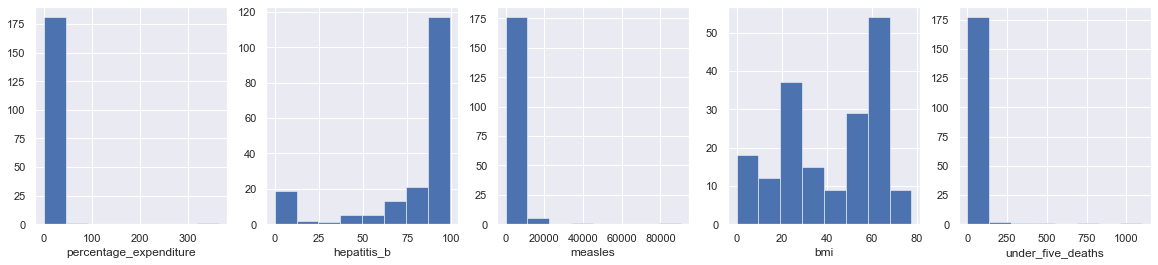

In [656]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for column_name, ax in zip(['percentage_expenditure',
                            'hepatitis_b',
                            'measles',
                            'bmi',
                            'under_five_deaths'], axes):
    ax.hist(le_2015[column_name], bins=8, linewidth=0.5, edgecolor="white")
    ax.set_xlabel(column_name)
    
plt.show()

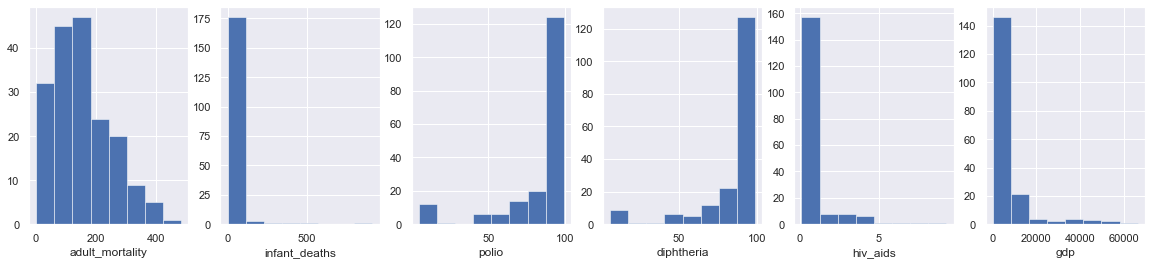

In [657]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for column_name, ax in zip(['adult_mortality',
                            'infant_deaths',
                            'polio',
                            'diphtheria',
                            'hiv_aids',
                            'gdp'], axes):
    ax.hist(le_2015[column_name], bins=8, linewidth=0.5, edgecolor="white")
    ax.set_xlabel(column_name)
    
plt.show()

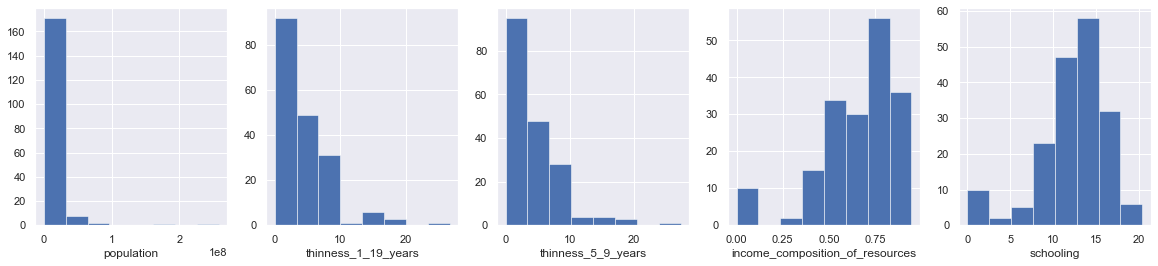

In [658]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for column_name, ax in zip(['population',
                             'thinness_1_19_years',
                             'thinness_5_9_years',
                             'income_composition_of_resources',
                             'schooling'], axes):
    ax.hist(le_2015[column_name], bins=8, linewidth=0.5, edgecolor="white")
    ax.set_xlabel(column_name)
    
plt.show()

#### Remove features with mostly zero values

In [659]:
le_2015['percentage_expenditure'].value_counts()

0.000000      181
71.279624       1
364.975229      1
Name: percentage_expenditure, dtype: int64

In [660]:
le_2015.drop('percentage_expenditure', axis=1, inplace=True)

#### Remove gdp and population features

> Since gdp and population have much wider ranges than the other features they will be removed.

In [661]:
le_2015['gdp'].value_counts()

0.000000        25
4737.669960      1
44292.884730     1
3821.893700      1
295.966488       1
                ..
41176.881580     1
1361.113950      1
187.789910       1
9212.192824      1
118.693830       1
Name: gdp, Length: 159, dtype: int64

In [662]:
le_2015['population'].value_counts()

0.0           40
33736494.0     1
18938513.0     1
28656282.0     1
16939923.0     1
              ..
81686611.0     1
27582821.0     1
182883.0       1
16252429.0     1
15777451.0     1
Name: population, Length: 144, dtype: int64

In [663]:
le_2015.drop(['gdp','population'], axis=1, inplace=True)

In [664]:
le_2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, Afghanistan to Zimbabwe
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             183 non-null    int64  
 1   status                           183 non-null    object 
 2   life_expectancy                  183 non-null    float64
 3   adult_mortality                  183 non-null    float64
 4   infant_deaths                    183 non-null    int64  
 5   hepatitis_b                      183 non-null    float64
 6   measles                          183 non-null    int64  
 7   bmi                              183 non-null    float64
 8   under_five_deaths                183 non-null    int64  
 9   polio                            183 non-null    float64
 10  diphtheria                       183 non-null    float64
 11  hiv_aids                         183 non-null    float64
 12  thinness_1_1

## Setup Training data and Target values

> X represents training data and y is the array of target values

In [665]:
X = le_2015.loc[:, ~le_2015.columns.isin(['index','country','year','status', 'life_expectancy'])]

In [666]:
X 

,adult_mortality,infant_deaths,hepatitis_b,measles,bmi,under_five_deaths,polio,diphtheria,hiv_aids,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,
Afghanistan,263.0,62,65.0,1154,19.1,83,6.0,65.0,0.1,17.2,17.3,0.479,10.1
Albania,74.0,0,99.0,0,58.0,0,99.0,99.0,0.1,1.2,1.3,0.762,14.2
Algeria,19.0,21,95.0,63,59.5,24,95.0,95.0,0.1,6.0,5.8,0.743,14.4
Angola,335.0,66,64.0,118,23.3,98,7.0,64.0,1.9,8.3,8.2,0.531,11.4
Antigua and Barbuda,13.0,0,99.0,0,47.7,0,86.0,99.0,0.2,3.3,3.3,0.784,13.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),157.0,9,87.0,0,62.1,10,87.0,87.0,0.1,1.6,1.5,0.769,14.3
Viet Nam,127.0,28,97.0,256,17.5,35,97.0,97.0,0.1,14.2,14.5,0.678,12.6
Yemen,224.0,37,69.0,468,41.3,47,63.0,69.0,0.1,13.6,13.4,0.499,9.0


In [667]:
X = X.to_numpy()

In [668]:
X

array([[263.   ,  62.   ,  65.   , ...,  17.3  ,   0.479,  10.1  ],
       [ 74.   ,   0.   ,  99.   , ...,   1.3  ,   0.762,  14.2  ],
       [ 19.   ,  21.   ,  95.   , ...,   5.8  ,   0.743,  14.4  ],
       ...,
       [224.   ,  37.   ,  69.   , ...,  13.4  ,   0.499,   9.   ],
       [ 33.   ,  27.   ,   9.   , ...,   6.1  ,   0.576,  12.5  ],
       [336.   ,  22.   ,  87.   , ...,   5.5  ,   0.507,  10.3  ]])

In [669]:
X.shape

(183, 13)

In [670]:
y = le_2015.loc[:, le_2015.columns.isin(['life_expectancy'])]

In [671]:
y

,life_expectancy
country,
Afghanistan,65.0
Albania,77.8
Algeria,75.6
Angola,52.4
Antigua and Barbuda,76.4
...,...
Venezuela (Bolivarian Republic of),74.1
Viet Nam,76.0
Yemen,65.7


In [672]:
y = y.to_numpy()

In [673]:
y.shape

(183, 1)

### Ridge Regression

In [674]:
lambdas = np.linspace(10,-2,100)

In [675]:
lambdas

array([10.        ,  9.87878788,  9.75757576,  9.63636364,  9.51515152,
        9.39393939,  9.27272727,  9.15151515,  9.03030303,  8.90909091,
        8.78787879,  8.66666667,  8.54545455,  8.42424242,  8.3030303 ,
        8.18181818,  8.06060606,  7.93939394,  7.81818182,  7.6969697 ,
        7.57575758,  7.45454545,  7.33333333,  7.21212121,  7.09090909,
        6.96969697,  6.84848485,  6.72727273,  6.60606061,  6.48484848,
        6.36363636,  6.24242424,  6.12121212,  6.        ,  5.87878788,
        5.75757576,  5.63636364,  5.51515152,  5.39393939,  5.27272727,
        5.15151515,  5.03030303,  4.90909091,  4.78787879,  4.66666667,
        4.54545455,  4.42424242,  4.3030303 ,  4.18181818,  4.06060606,
        3.93939394,  3.81818182,  3.6969697 ,  3.57575758,  3.45454545,
        3.33333333,  3.21212121,  3.09090909,  2.96969697,  2.84848485,
        2.72727273,  2.60606061,  2.48484848,  2.36363636,  2.24242424,
        2.12121212,  2.        ,  1.87878788,  1.75757576,  1.63

In [676]:
fold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
ridge = RidgeCV(alphas=lambdas, cv=fold, normalize = True)
ridge.fit(X, y)

RidgeCV(alphas=array([10.        ,  9.87878788,  9.75757576,  9.63636364,  9.51515152,
        9.39393939,  9.27272727,  9.15151515,  9.03030303,  8.90909091,
        8.78787879,  8.66666667,  8.54545455,  8.42424242,  8.3030303 ,
        8.18181818,  8.06060606,  7.93939394,  7.81818182,  7.6969697 ,
        7.57575758,  7.45454545,  7.33333333,  7.21212121,  7.09090909,
        6.96969697,  6.84848485,  6.72727273,  6.60606061,  6.48484848,
        6.36363...
        0.90909091,  0.78787879,  0.66666667,  0.54545455,  0.42424242,
        0.3030303 ,  0.18181818,  0.06060606, -0.06060606, -0.18181818,
       -0.3030303 , -0.42424242, -0.54545455, -0.66666667, -0.78787879,
       -0.90909091, -1.03030303, -1.15151515, -1.27272727, -1.39393939,
       -1.51515152, -1.63636364, -1.75757576, -1.87878788, -2.        ]),
        cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=1),
        normalize=True)

In [677]:
def get_cross_val_scores(reg, X, y, fold):
    MSE = cross_val_score(reg, X, y, scoring='neg_mean_squared_error', cv=fold).mean()
    print(f'MSE = {-MSE}')
    RMSE = cross_val_score(reg, X, y, scoring='neg_root_mean_squared_error', cv=fold).mean()
    print(f'RMSE = {-RMSE}')
    MAE = cross_val_score(reg, X, y, scoring='neg_mean_absolute_error', cv=fold).mean()
    print(f'MAE = {-MAE}')
    r2 = cross_val_score(reg, X, y, scoring='explained_variance', cv=fold).mean()
    print(f'R-Squared = {r2}')    

#### Get cross validation scores for Ridge Regression

In [678]:
get_cross_val_scores(ridge, X, y, fold)

MSE = 17.387850573500394
RMSE = 4.068653006761957
MAE = 3.061774002874028
R-Squared = 0.6889177355643399


In [679]:
ridge.alpha_

0.18181818181818166

In [680]:
ridge.coef_

array([[-2.89523228e-02,  2.58264474e-03, -2.22311830e-02,
         2.06115512e-05,  4.53859547e-02, -1.91732692e-03,
         3.77463409e-02,  6.24334648e-02, -8.28784805e-01,
        -1.80444494e-01, -1.34260022e-01,  5.37307181e+00,
         1.63912576e-01]])

In [681]:
ridge.intercept_

array([63.85683437])

### LASSO Regression

In [682]:
lasso = LassoCV(alphas = lambdas, cv=fold, normalize = True)
lasso.fit(X, y)

LassoCV(alphas=array([10.        ,  9.87878788,  9.75757576,  9.63636364,  9.51515152,
        9.39393939,  9.27272727,  9.15151515,  9.03030303,  8.90909091,
        8.78787879,  8.66666667,  8.54545455,  8.42424242,  8.3030303 ,
        8.18181818,  8.06060606,  7.93939394,  7.81818182,  7.6969697 ,
        7.57575758,  7.45454545,  7.33333333,  7.21212121,  7.09090909,
        6.96969697,  6.84848485,  6.72727273,  6.60606061,  6.48484848,
        6.36363...
        0.90909091,  0.78787879,  0.66666667,  0.54545455,  0.42424242,
        0.3030303 ,  0.18181818,  0.06060606, -0.06060606, -0.18181818,
       -0.3030303 , -0.42424242, -0.54545455, -0.66666667, -0.78787879,
       -0.90909091, -1.03030303, -1.15151515, -1.27272727, -1.39393939,
       -1.51515152, -1.63636364, -1.75757576, -1.87878788, -2.        ]),
        cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=1),
        normalize=True)

In [683]:
get_cross_val_scores(lasso, X, y, fold)

MSE = 19.474987021995503
RMSE = 4.2319837435136165
MAE = 3.2490164355292457
R-Squared = 0.6792253044435533


In [684]:
lasso.alpha_

0.06060606060606055

In [685]:
lasso.coef_

array([-0.03560725, -0.        , -0.        ,  0.        ,  0.03234499,
       -0.        ,  0.0216706 ,  0.04060793, -0.38905524, -0.20322936,
       -0.        ,  7.0571242 ,  0.        ])

In [686]:
lasso.intercept_

67.00587880207482

### Summary

- The Ridge Regression and LASSO regression models produced similar R-Squared values (Ridge R-Squared was 0.68 and LASSO R-Squared was 0.67)
- Both models had similar MSE, RMSE, and MAE scores 
- The LASSO regression was able to produce similiar cross validation scores as Ridge regression by using only seven features as opposed to all thirteen features